# ECE 47300 Assignment 6 Exercise

Your Name:

Objective: Build an RNN model to predict the next character in a sequence of text data from Shakespeare's plays.

# Exercise  1: Data Preprocessing (30 points)
In this part, you will implement some preprocessing functions.
Run the following code to load the text data from the given file "shakespeare.txt". Do not change the random seed.

In [2]:
import numpy as np
! pip install unidecode
import unidecode
import string
import time
import torch
import pdb

import torch.nn as nn
from torch.autograd import Variable

all_characters = string.printable
print(all_characters)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.3 MB/s eta 0:00:00
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



Follow the step on the instructions and mount your google drive on Colab which allows to access the .txt file uploaded on your drive that was included with this assignment.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file

dir_root = '/content/drive/MyDrive/ECE 473/Assignment-6'     # Your assignment dir
file_path = dir_root + '/shakespeare.txt'
file = read_file(file_path)
file_len = len(file)
print(f"file length: {file_len}")
print(file[:100])

file length: 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### Task 1: Implement function to get a random chunk of Shakespeare text (15 points)
The `get_random_chunk` function is a helper function that generates a random chunk of **input text data** and **output text data** (which is one character shifted from the input) from the Shakespeare dataset.
Specifically, the `chunk_len` argument specifies the size of the input and output sequences.
For example, if `chunk_len=4`, then a valid return value would be the two chunks:
`('Befo','efor')` or `('proc','roce')`.
This function is useful
in generating diverse sets of input data for training the RNN model in the assignment.

Hints:
- Start from a random index of the file (but note that the max index must be small enough so that a full chunk can be extracted).
- Based on this random start index, extract `chunk_len` characters for the input sequence and `chunk_len` characters for the output sequence (shifted one character to the right).

In [5]:
def get_random_chunk(file, rng, chunk_len = 100):
    ######### Your Code Here ###########
    start = rng.randint(0, len(file) - chunk_len - 1)

    return file[start:start + chunk_len], file[start + 1:start + chunk_len + 1]
    ######### End of your code #########

rng = np.random.RandomState(123) # use this if you need to generate a random sample
curr_chunk, next_chunk = get_random_chunk(file='Hello world!', rng=rng, chunk_len=10)
print(f"curr_chunk =>{curr_chunk}\n next_chunk=> {next_chunk}")

print(f"Is curr_chunk and next_chunk same length: {len(curr_chunk) == len(next_chunk)}")
print(f"Is next chunk shifted by one: {curr_chunk[1:] == next_chunk[:-1]}")


curr_chunk =>Hello worl
 next_chunk=> ello world
Is curr_chunk and next_chunk same length: True
Is next chunk shifted by one: True


### Task 2: Implement function to convert to tensors (15 points)

Define a function `to_tensor(string)` that takes a string of characters as input and return torch tensor as output, similar to in the demo in class.
Specifically,
1. Create an empty tensor of shape `(len(string), 1, len(all_characters))` using the PyTorch `torch.zeros` function,
    where `len(string)` is the length of the input string, 1 is the batch size, and `len(all_characters)` is the total
    number of unique characters in the text data.
2. Loop through each character in the input string and convert it to a one-hot encoded vector.

In [6]:
def to_tensor(string):
######### Your Code Here ###########
  tensor = torch.zeros(len(string), 1, len(all_characters))
  for li in range(len(string)):
    letter = string[li]
    tensor[li][0][all_characters.find(letter)] = 1
  return tensor
######### End of your code #########

def get_one_hot_tensors(input, output):
    return to_tensor(input), to_tensor(output)

rng = np.random.RandomState(123) # use this if you need to generate a random sample
input, output = get_random_chunk(file, rng,  50)
print(input.replace('\n', ' '))
print(output.replace('\n', ' '))
input_tensor, output_tensor = get_one_hot_tensors(input, output)
print(f"input shape: {input_tensor.shape}")
print(f"output shape: {output_tensor.shape}")

g's, which Florizel I now name to you; and with sp
's, which Florizel I now name to you; and with spe
input shape: torch.Size([50, 1, 100])
output shape: torch.Size([50, 1, 100])


# Exercise  2: Build the RNN model (30 points)

In this part, you will build the RNN model using PyTorch.
- nn.GRU is used to implement the GRU algorithm for processing sequential input data.
    - https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
- The decoder layer is a fully connected neural network layer that maps the output of the GRU layer to the desired output size.
- As we are only implementing a single layer RNN, the model is not powerful enough to learn long-term dependencies in the text data. So don't be surprised if the output sentences are not very meaningful. We are providing you loss plots (`gru_loss_ex2.png`) to help you check if your code is working correctly.

In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        # Define modules of RNN
        ######### Your Code Here ###########
        # Set `self.rnn_cell` to a nn.GRU
        self.rnn_cell = nn.GRU(hidden_size, hidden_size)
        # Define a linear decoder layer that maps from the hidden size to the output size
        self.decoder = nn.Linear(hidden_size, output_size)
        ######### End of your code #########

    def forward(self, input, hidden):
        ######### Your Code Here ###########
        # 1. Reshape the input to (1, 1, -1) and pass it to the GRU layer
        # 2. Reshape the rnn_cell output to (1, -1) and pass it to the decoder layer
        input = input.view(1, 1, -1)
        output, hidden = self.rnn_cell(input, hidden)
        output = output.view(1, -1)
        output = self.decoder(output)
        ######### End of your code #########
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [8]:
def train(inp, target, decoder):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    input_tensor, target_tensor = get_one_hot_tensors(inp, target)
    for c in range(len(inp)):
        output, hidden = decoder(input_tensor[c], hidden)
        loss += criterion(output, torch.argmax(target_tensor[c]).unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()
    return loss.item() / max_length

In [9]:
def evaluate(decoder, prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        out, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = to_tensor(predicted_char)

    return predicted

[(100 5.0%) 2.844596252441406]
Whetde, nN meale.dtAI ne ame nden
iIaal gl Oovar p au manerGss pe sed vecnyn ne n s, tooow  henwd teso 

[(200 10.0%) 2.4116787719726562]
Whean thend will bon amy cond foty :
The moudsaicrerat cir, four bes intha tue tiectord tou te mind we 

[(300 15.0%) 2.7210711669921874]
Whon, not he hay ingrss the satng cee, noleca th hey psertor Not and s me ss thond, dot?

Ihs ile she  

[(400 20.0%) 2.447781982421875]
Who githy mean.

PLOY:
Will Your,
I lout mowe,
Mave timy our.

Tor iit thet for
Coring in the ouchebre 

[(500 25.0%) 2.2613043212890624]
Whak novell have in thin sprow fare ard ald hill mus the noun warl the vestot wird mill the wis dos li 

[(600 30.0%) 2.2170071411132812]
Whal seve masit saiss the bey, Hat chay ghan be the teestay and, not forfaat and the mush rage the dat 

[(700 35.0%) 2.2697198486328123]
Wha lave buon the jus dour you INGy VO Gor:
Ko has wers ward on theme sse ug her and so keusis to wor  

[(800 40.0%) 2.112163543701172]
Why m

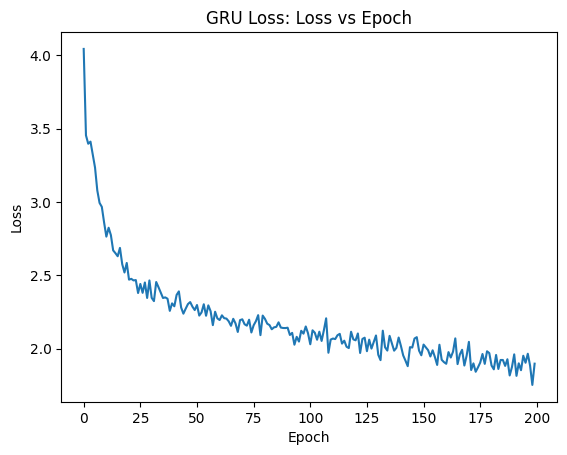

In [10]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005
max_length = len(all_characters)

decoder = RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
rng = np.random.RandomState(123) # use this if you need to generate a random sample

for epoch in range(1, n_epochs + 1):
    loss = train(*get_random_chunk(file, rng), decoder)
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        print(evaluate(decoder, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print(f"______________________________________________________________")
print(evaluate(decoder, 'Th', 200, temperature=0.2))

import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.title("GRU Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Exercise  3: Implement an LSTM model (30 points)

Using the equations from the slides in class, write your own LSTM cell module.
The code below will use this instead of the GRU cell module and train the model.

Notes:
- Note that for LSTM the hidden state is really both the $h_t$ and $C_t$ so we just unpack the passed hidden state into these two variables at the beginning, and pack them into a tuple for returning.
- We apply a single linear layer to compute all the linear parts of the model that operate on $h'_{t-1}$ and then unpack these using `chunk(4)` into the four separate parts. This is equivalent to having 4 separate linear layers.
- As we are only implementing a single layer RNN, the model is not powerful enough to learn long-term dependencies in the text data. So don't be surprised if the output sentences are not very meaningful. We are providing you loss plots (`lstm_loss_ex3.png`) to help you check if your code is working correctly.

In [11]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hidden=None):
        # Unpack hidden state and cell state
        hx, cx = hidden

        # Apply linear layers to input and hidden state
        linear = self.xh(input) + self.hh(hx)

        # Get outputs of applying a linear transform for each part of the LSTM
        input_linear, forget_linear, cell_linear, output_linear = linear.reshape(-1).chunk(4)     # h'_t in the slides

        ######### Your Code Here ###########
        # 1. Apply activation functions to get gates and new cell state information
        # 2. Calculate the new cell state (c_new)
        # 3. Calculate the new hidden state (h_new)
        C_t = torch.tanh(cell_linear)
        f_t = torch.sigmoid(forget_linear)
        i_t = torch.sigmoid(input_linear)
        o_t = torch.sigmoid(output_linear)

        c_new = f_t*cx + i_t*C_t
        h_new = o_t*torch.tanh(c_new)

        ######### End of your code #########

        # Pack cell state $C_t$ and hidden state $h_t$ into a single hidden state tuple
        output = h_new # For LSTM the output is just the hidden state
        hidden = (h_new, c_new) # Packed h and C
        return output, hidden



[(100 5.0%) 3.1686196899414063]
Wha4ihon
v'nros
iotc CtceomT   nin h   b oAon-  thIhn,s
a, h,
wcm
o geso;elfies
uNe5ut o  eooldtot eet 

[(200 10.0%) 3.1097097778320313]
Whuty eeuac,o s oeoyto:e te  eardesacaue ur fr tcrIesrsi  i;rr   ooi
 r notbbd neLim wSrtooo cry   rit 

[(300 15.0%) 3.479144287109375]
WhRTwhp ti nHa f a. m teNt dw
daoEUie d
 ,  ,
heb ele!ne  rapal
 a httn iahe
 tnelhe
Io,as h aisewmlh 

[(400 20.0%) 3.296087341308594]
Wh:heas
yd:orlcidaI sote A R at ie es akac warE aos te, tow satm r', 
 seh nNoHe
w iarlioo,es m re  Wr 

[(500 25.0%) 2.884673767089844]
Whhe moy cbte ahamens,a 
eht moot rise
sec
knrt whe char:il at no,nl
 mt Lvere fua the ol st vd acl pu 

[(600 30.0%) 2.7456631469726562]
Whchl boryinr 
atatsp thos sot tatnedesm 
at ikt mrot tCa d yatipheoae ti tc yrss th nil  uusl med hre 

[(700 35.0%) 2.8002896118164062]
Why aon itain mme thy se, thels muc
 torse yith thenn eoe hoss if ee nh mhin tt yhihe hrthe oo s, lo a 

[(800 40.0%) 2.5577984619140626]
Whe I

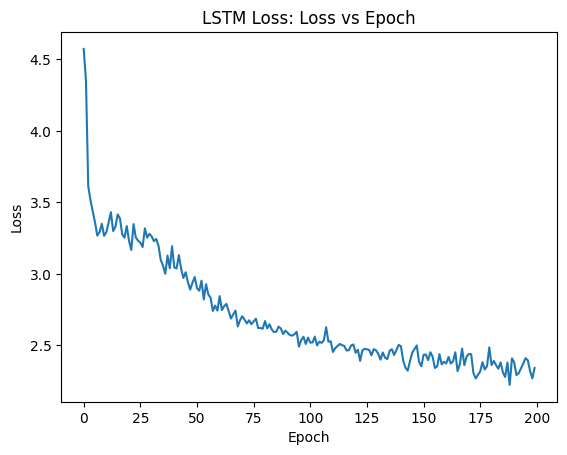

In [17]:
lr = 0.001
class LSTM_RNN(RNN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Replace the gru cell with LSTM cell
        self.rnn_cell = LSTMCell(max_length, hidden_size, max_length)

    def init_hidden(self):
        # LSTM cells need two hidden variables in a tuple of (h_t,C_t)
        return (Variable(torch.zeros(1, 1, self.hidden_size)), Variable(torch.zeros(1, 1, self.hidden_size)))

decoder = LSTM_RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

all_losses = []
loss_avg = 0
rng = np.random.RandomState(123) # use this if you need to generate a random sample

for epoch in range(1, n_epochs + 1):
    loss = train(*get_random_chunk(file, rng),decoder)
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        print(evaluate(decoder, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print(f"______________________________________________________________")
print(evaluate(decoder, 'Th', 200, temperature=0.2))

plt.plot(all_losses)
plt.title("LSTM Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Exercise 4: Implement your own GRU (10 points)

Same as above but implement a GRU instead of an LSTM module. An exmaple of GRU architecture can be found from the lecture slide: https://www.davidinouye.com/course/ece57000-fall-2023/lectures/recurrent-neural-networks.pdf

You output loss plot should be similar in Exercise 2.

In [26]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.h2z = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2r = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2h = nn.Linear(input_size + hidden_size, hidden_size)

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Output:
        #       h_t, h_t: h_t is of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))

        ######### Your Code Here ###########

        # Concatenate hidden and input to get h_prime (see torch.cat)
        hidden_cat = torch.cat((hx,input), 2)
        # Use self.h2z to calculate z_t
        z_t = torch.sigmoid(self.h2z(hidden_cat))
        # Use self.h2r to calculate r_t
        r_t = torch.sigmoid(self.h2r(hidden_cat))
        # Use Hadamard product of r_t and hx and concatenate with input
        # Then use h2h to calculate new hidden information h_tbar
        h_tbar = torch.tanh( self.h2h( torch.cat((r_t*hx, input), 2) ) )
        # Update h_t with z_t, hx, and h_tbar
        h_t = (1-z_t)*hx + z_t*h_tbar

        ######### End of your code #########

        # Reshape h_t match input size
        h_t = h_t.reshape(1, 1, -1)

        return h_t, h_t   # Output and hidden are both h_t

[(100 5.0%) 2.7945632934570312]
Wheisspd rinousicoocos.

Le:
h meso, ol.y southernd torRinetoc id besve sot eey ro herf sp
r cartone d 

[(200 10.0%) 2.3955044555664062]
Whe nThes yoal;
Heearderererim,

im mime tr wlllund ailr vouu,
Whe whad te
Oer,
Eeruw wo tie he
pour a 

[(300 15.0%) 2.7422671508789063]
Whein in the nout mury mond, net hoy she mamenLe ho distis wong dotie my hik st ain theing in that hea 

[(400 20.0%) 2.4138829040527345]
Whyour mave, the the stish ie wnoo Large?

TLGEMEIEA:
Your and heace sewa and at coall;.
An port in th 

[(500 25.0%) 2.179210205078125]
Whet wowl.

PAMAGLO:
Mef cretver's whal  foughipy the bege het with me cow ordor, gourft,
But ang, dou 

[(600 30.0%) 2.136307830810547]
Whe here so the mo do-!
For me, wath me thies thee you dood brong much so the
But!

GIO:
Ang the the s 

[(700 35.0%) 2.2376153564453123]
Where him be wat the met sond so his an com, and of mos you morTill in a wore hase bestyour but so so  

[(800 40.0%) 2.0451402282714843]
Wher

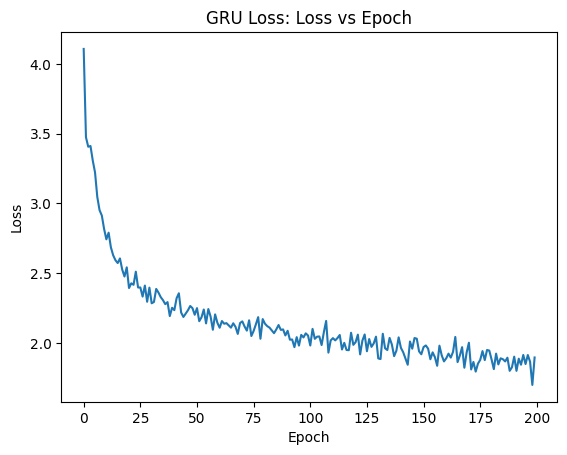

In [30]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005
max_length = len(all_characters)

# Replace the RNN module with your implemented GRUcell
class GRU_RNN(RNN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Replace wtih your gru cell
        self.rnn_cell = GRUCell(max_length, hidden_size, max_length)

decoder = GRU_RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

all_losses = []
loss_avg = 0
rng = np.random.RandomState(123) # use this if you need to generate a random sample

for epoch in range(1, n_epochs + 1):
    loss = train(*get_random_chunk(file, rng),decoder)
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        print(evaluate(decoder, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print(f"______________________________________________________________")
print(evaluate(decoder, 'Th', 200, temperature=0.2))

plt.plot(all_losses)
plt.title("GRU Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()